## Libraries

In [1]:
import os
import cv2
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import json
from comet_ml import Experiment
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input

2024-08-26 05:47:39.426541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 05:47:39.714988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 05:47:39.793958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 05:47:40.388444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 05:47:43.275756: W tensorflow/compiler/tf2

In [2]:
%load_ext tensorboard

## Load Data

In [3]:
train_dir = r"/home/ayman/AI Projects/Iris Detection/iris_data/aug_data/train"
test_dir = r"/home/ayman/AI Projects/Iris Detection/iris_data/aug_data/test"
val_dir = r"/home/ayman/AI Projects/Iris Detection/iris_data/aug_data/val"
train_images_dir = os.path.join(train_dir, "images")
train_labels_dir = os.path.join(train_dir, "labels")
test_images_dir = os.path.join(test_dir, "images")
test_labels_dir = os.path.join(test_dir, "labels")
val_images_dir = os.path.join(val_dir, "images")
val_labels_dir = os.path.join(val_dir, "labels")

In [4]:
resolution = 224

In [5]:
def load_image(image_path, resolution, model_type='efficientnet'):
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [resolution, resolution])
    
    if model_type == 'efficientnet':
        image = efficientnet_preprocess_input(image)
    elif model_type == 'resnet':
        image = resnet_preprocess_input(image)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    return image


def load_label(label_path):
    def parse_json(file_path):
        with open(file_path.decode('utf-8'), 'r') as f:
            data = json.load(f)
            return np.array(data['keypoints'], dtype=np.float16)

    # Use tf.numpy_function to wrap the custom function
    label = tf.numpy_function(parse_json, [label_path], tf.float16)
    # Specify the output shape
    label.set_shape([4])  # Adjust based on your actual label size

    return label

def data_generator(image_paths, label_paths, batch_size=32, augment=False, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    dataset = dataset.map(lambda x, y: (load_image(x, resolution=resolution), load_label(y)), num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        def augment(image, label):
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_brightness(image, 0.2)
            return image, label
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

def get_sorted_file_paths(image_dir, label_dir):
    image_paths = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png') or file.endswith('.jpg')])
    label_paths = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.endswith('.json')])
    
    if len(image_paths) != len(label_paths):
        raise ValueError("Number of images and labels do not match")
    
    return image_paths, label_paths

In [6]:
batch_size = 100

In [7]:
len(os.listdir(train_images_dir)), len(os.listdir(train_labels_dir))

(7250, 7250)

In [8]:
train_image_paths, train_label_paths = get_sorted_file_paths(train_images_dir, train_labels_dir)
test_image_paths, test_label_paths = get_sorted_file_paths(test_images_dir, test_labels_dir)
val_image_paths, val_label_paths = get_sorted_file_paths(val_images_dir, val_labels_dir)

train_gen = data_generator(train_image_paths, train_label_paths, shuffle=True, batch_size=batch_size)
test_gen = data_generator(test_image_paths, test_label_paths, shuffle=False, batch_size=batch_size)
val_gen = data_generator(val_image_paths, val_label_paths, shuffle=False, batch_size=batch_size)

I0000 00:00:1724640471.351758  204523 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724640472.083324  204523 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724640472.083533  204523 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724640472.089013  204523 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724640472.089167  204523 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [9]:
data_iter = iter(train_gen)

In [10]:
X_train, y_train = next(data_iter)

In [11]:
X_train.shape, y_train.shape

(TensorShape([100, 224, 224, 3]), TensorShape([100, 4]))

In [12]:
y_train[0]

<tf.Tensor: shape=(4,), dtype=float16, numpy=array([0.361 , 0.3328, 0.4385, 0.3574], dtype=float16)>

In [13]:
for i in range(3):
    print("Image path:", train_image_paths[i])
    print("Label:", y_train[i])

Image path: /home/ayman/AI Projects/Iris Detection/iris_data/aug_data/train/images/26f54047-5bda-11ef-a436-c18859564890.0.png
Label: tf.Tensor([0.361  0.3328 0.4385 0.3574], shape=(4,), dtype=float16)
Image path: /home/ayman/AI Projects/Iris Detection/iris_data/aug_data/train/images/26f54047-5bda-11ef-a436-c18859564890.1.png
Label: tf.Tensor([0.2267 0.292  0.3416 0.266 ], shape=(4,), dtype=float16)
Image path: /home/ayman/AI Projects/Iris Detection/iris_data/aug_data/train/images/26f54047-5bda-11ef-a436-c18859564890.10.png
Label: tf.Tensor([0.3198 0.3606 0.2423 0.4114], shape=(4,), dtype=float16)


In [14]:
X_train[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[102.53571 , 103.67729 , 107.761475],
        [117.70153 , 124.386475, 128.13521 ],
        [137.54208 , 142.67091 , 148.84311 ],
        ...,
        [187.46184 , 193.60704 , 183.93727 ],
        [189.92616 , 191.75122 , 195.14044 ],
        [192.20003 , 194.94533 , 198.40291 ]],

       [[103.60332 ,  99.41581 , 107.688774],
        [115.78189 , 123.19388 , 124.      ],
        [136.99362 , 143.3699  , 145.02296 ],
        ...,
        [180.65329 , 192.50636 , 190.89958 ],
        [189.50758 , 195.33423 , 198.4235  ],
        [190.92728 , 195.25137 , 196.06381 ]],

       [[ 94.46938 ,  99.97832 , 102.34311 ],
        [111.13265 , 117.11224 , 118.55485 ],
        [133.11862 , 139.14668 , 144.78444 ],
        ...,
        [185.28702 , 193.28812 , 192.60303 ],
        [190.00876 , 193.77704 , 197.52931 ],
        [192.88875 , 193.45923 , 200.75119 ]],

       ...,

       [[ 54.226902,  54.156986,  55.205738],
        [ 53.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0: Coord1 (80, 74), Coord2 (98, 80)
Image 1: Coord1 (50, 65), Coord2 (76, 59)
Image 2: Coord1 (71, 80), Coord2 (54, 92)
Image 3: Coord1 (35, 87), Coord2 (53, 79)
Image 4: Coord1 (126, 87), Coord2 (107, 78)
Image 5: Coord1 (105, 57), Coord2 (83, 43)
Image 6: Coord1 (31, 81), Coord2 (45, 74)
Image 7: Coord1 (69, 76), Coord2 (87, 68)
Image 8: Coord1 (79, 60), Coord2 (94, 65)


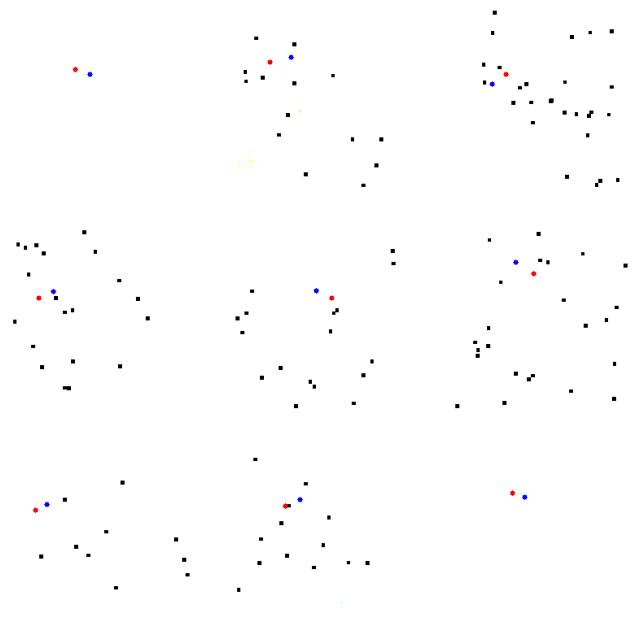

In [15]:
# Reverse the EfficientNet preprocessing
def reverse_efficientnet_preprocess(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image * std) + mean  # Reverse the normalization
    image = np.clip(image * 255, 0, 255).astype(np.uint8)
    return image # Convert back to [0, 255]

# Adjust the coordinates to match the original image resolution
def correct_coordinates(label, image_size=(resolution, resolution)):
    return tuple(np.multiply(label, image_size).astype(int))

# Plotting the images and the keypoints
fig, ax = plt.subplots(3, 3, figsize=(8, 8))

# Choose the preprocessing method
model_type = 'efficientnet'  # or 'resnet' depending on your original model

for i in range(9):
    sample_image = X_train[i].numpy()
    # Reverse the preprocessing
    # sample_image = reverse_efficientnet_preprocess(sample_image)
    
    sample_image = np.array(sample_image, dtype=np.float32)
    
    sample_label = y_train[i].numpy()
    
    # Correct the coordinates based on original resolution
    coord1 = correct_coordinates(sample_label[0:2])
    coord2 = correct_coordinates(sample_label[2:4])
    
    print(f"Image {i}: Coord1 {coord1}, Coord2 {coord2}")
    
    # Draw circles for the keypoints
    cv2.circle(sample_image, coord1, 3, (255, 0, 0), -1)
    cv2.circle(sample_image, coord2, 3, (0, 0, 255), -1)
    
    ax[i//3, i%3].imshow(sample_image)
    ax[i//3, i%3].axis('off')

plt.show()

## Modelling

In [16]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3

1. Backbone Architecture

In [17]:
backbone = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=layers.Input(batch_shape=(None, resolution, resolution, 3)))

2. Full Architecture

In [18]:
# freeze layers
# for layer in backbone.layers[:-31]:
#     layer.trainable = False
backbone.layers[0] = layers.Conv2D(40, 3,  padding='same', activation='relu', input_shape=(resolution, resolution, 3), use_bias=False)

model = models.Sequential()
x = backbone.output
x = layers.Conv2D(256, 3, padding='same' ,activation='relu')(x)
x = layers.BatchNormalization()(x)
# x = layers.Conv2D(512, 3, padding='same' ,activation='relu')(x)
# x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, padding='same' ,activation='relu')(x)
x = layers.BatchNormalization()(x)
# x = layers.Conv2D(256, 3, padding='same' ,activation='relu')(x)
# x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3,  padding='same' ,activation='relu')(x)
x = layers.BatchNormalization()(x)
# x = layers.Conv2D(128, 3,2, padding='same' ,activation='relu')(x)

x = layers.Dropout(0.5)(x)
x = layers.Conv2D(4, (2, 2), activation='linear')(x)
x = layers.GlobalAveragePooling2D()(x)


model = models.Model(backbone.input, x, name='Iris_Detection_ModelV4')
# model.summary()

/home/ayman/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3. Compiling

In [19]:
# set policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [20]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, beta_1=0.9, beta_2=0.937, weight_decay=0.007)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
loss = tf.keras.losses.Huber(delta=0.2)
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae'])

In [21]:
def cosine_schedule_with_warmup(epoch):
    min_lr = 1e-5
    max_lr = 1e-3
    warmup_epochs = 10
    total_epochs = 80  # Set this to the total number of epochs for your training

    if epoch < warmup_epochs:
        # Linear warmup
        lr = (max_lr - min_lr) / warmup_epochs * epoch + min_lr
    else:
        # Cosine annealing after warmup
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(progress * np.pi))
    
    return lr

# Create a callback for the learning rate schedule
lr_callback = tf.keras.callbacks.LearningRateScheduler(cosine_schedule_with_warmup)

In [22]:
# steps_per_epoch = len(train_image_paths) // batch_size
# validation_steps = len(val_image_paths) // batch_size

In [23]:
experiment = Experiment(
    api_key="yIHOp6Gk4OJB5NKzKJ2S1v1nu",
    project_name="iris-detection",
)
writer = tf.summary.create_file_writer("./logs")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/aymansab0/iris-detection/594ee119b93a42e4b6d761091982cdf3



In [24]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [25]:
# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# Model checkpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_2.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [26]:
with experiment.train():
    history = model.fit(train_gen, epochs = 80, validation_data=val_gen, callbacks=[lr_callback, tensorboard_callback, model_checkpoint_callback])

COMET INFO: Couldn't find a Git repository in '/home/ayman/AI Projects/Iris Detection/iris_data' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Epoch 1/80


I0000 00:00:1724640547.128364  204610 service.cc:146] XLA service 0x7f79dc003460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724640547.128559  204610 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-26 05:49:08.060312: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-26 05:49:16.205839: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-26 05:49:56.494734: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=1,k5=2,k14=5} for conv (f32[100,144,113,113]{3,2,1,0}, u8[0]{0}) custom-call(f32[100,144,115,115]{3,2,1,0}, f32[144,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=144, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id

72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 0.0705 - mae: 0.4430 - mse: 0.3141

E0000 00:00:1724640777.076903  204610 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724640777.344505  204610 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0704 - mae: 0.4422 - mse: 0.3131   

2024-08-26 05:54:29.103419: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 849346560 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.03683, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - loss: 0.0702 - mae: 0.4415 - mse: 0.3123 - val_loss: 0.0368 - val_mae: 0.2741 - val_mse: 0.1005 - learning_rate: 1.0000e-05
Epoch 2/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 0.0370 - mae: 0.2687 - mse: 0.1205

2024-08-26 05:55:31.655715: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 849346560 exceeds 10% of free system memory.



Epoch 2: val_loss did not improve from 0.03683
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 661ms/step - loss: 0.0369 - mae: 0.2682 - mse: 0.1201 - val_loss: 0.0503 - val_mae: 0.3344 - val_mse: 0.2238 - learning_rate: 1.0900e-04
Epoch 3/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.0162 - mae: 0.1454 - mse: 0.0678

2024-08-26 05:56:17.684717: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 849346560 exceeds 10% of free system memory.



Epoch 3: val_loss improved from 0.03683 to 0.00709, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 59s 805ms/step - loss: 0.0162 - mae: 0.1451 - mse: 0.0678 - val_loss: 0.0071 - val_mae: 0.0963 - val_mse: 0.0279 - learning_rate: 2.0800e-04
Epoch 4/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 0.0087 - mae: 0.0910 - mse: 0.0616

2024-08-26 05:57:18.280108: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 849346560 exceeds 10% of free system memory.



Epoch 4: val_loss improved from 0.00709 to 0.00345, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 61s 793ms/step - loss: 0.0087 - mae: 0.0909 - mse: 0.0615 - val_loss: 0.0035 - val_mae: 0.0624 - val_mse: 0.0084 - learning_rate: 3.0700e-04
Epoch 5/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.0076 - mae: 0.0796 - mse: 0.0635

2024-08-26 05:58:21.548328: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 849346560 exceeds 10% of free system memory.



Epoch 5: val_loss improved from 0.00345 to 0.00156, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 61s 826ms/step - loss: 0.0076 - mae: 0.0796 - mse: 0.0635 - val_loss: 0.0016 - val_mae: 0.0356 - val_mse: 0.0035 - learning_rate: 4.0600e-04
Epoch 6/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.0060 - mae: 0.0664 - mse: 0.0439
Epoch 6: val_loss did not improve from 0.00156
73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 619ms/step - loss: 0.0060 - mae: 0.0664 - mse: 0.0439 - val_loss: 0.0030 - val_mae: 0.0558 - val_mse: 0.0072 - learning_rate: 5.0500e-04
Epoch 7/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.0065 - mae: 0.0692 - mse: 0.0536
Epoch 7: val_loss did not improve from 0.00156
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 622ms/step - loss: 0.0065 - mae: 0.0692 - mse: 0.0535 - val_loss: 0.0019 - val_mae: 0.0391 - val_mse: 0.0044 - learning_rate: 6.0400e-04
Epoch 8/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 0.0054 - mae: 0.0601 - mse: 0.0409
Epoch 8: val_loss did not imp

2024-08-26 06:03:45.097876: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 12: val_loss did not improve from 0.00156
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 607ms/step - loss: 0.0030 - mae: 0.0392 - mse: 0.0171 - val_loss: 0.0022 - val_mae: 0.0403 - val_mse: 0.0059 - learning_rate: 9.9950e-04
Epoch 13/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.0028 - mae: 0.0378 - mse: 0.0159
Epoch 13: val_loss did not improve from 0.00156
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 678ms/step - loss: 0.0028 - mae: 0.0377 - mse: 0.0159 - val_loss: 0.0016 - val_mae: 0.0286 - val_mse: 0.0039 - learning_rate: 9.9801e-04
Epoch 14/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.0025 - mae: 0.0331 - mse: 0.0133

2024-08-26 06:05:19.852136: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_loss improved from 0.00156 to 0.00148, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 58s 791ms/step - loss: 0.0025 - mae: 0.0331 - mse: 0.0132 - val_loss: 0.0015 - val_mae: 0.0277 - val_mse: 0.0035 - learning_rate: 9.9552e-04
Epoch 15/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 0.0019 - mae: 0.0295 - mse: 0.0083

2024-08-26 06:06:21.305906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 15: val_loss improved from 0.00148 to 0.00107, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 60s 776ms/step - loss: 0.0019 - mae: 0.0295 - mse: 0.0083 - val_loss: 0.0011 - val_mae: 0.0252 - val_mse: 0.0027 - learning_rate: 9.9205e-04
Epoch 16/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 0.0018 - mae: 0.0289 - mse: 0.0074
Epoch 16: val_loss did not improve from 0.00107
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 620ms/step - loss: 0.0018 - mae: 0.0289 - mse: 0.0074 - val_loss: 0.0149 - val_mae: 0.0967 - val_mse: 0.6264 - learning_rate: 9.8759e-04
Epoch 17/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 0.0018 - mae: 0.0282 - mse: 0.0075
Epoch 17: val_loss did not improve from 0.00107
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 674ms/step - loss: 0.0018 - mae: 0.0283 - mse: 0.0075 - val_loss: 0.0013 - val_mae: 0.0288 - val_mse: 0.0032 - learning_rate: 9.8216e-04
Epoch 18/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 0.0015 - mae: 0.0268 - mse: 0.0047
Epoch 18: val_loss did 

2024-08-26 06:10:32.776310: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 20: val_loss did not improve from 0.00107
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 586ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0030 - val_loss: 0.0011 - val_mae: 0.0224 - val_mse: 0.0028 - learning_rate: 9.6017e-04
Epoch 21/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 9.4911e-04 - mae: 0.0218 - mse: 0.0024
Epoch 21: val_loss improved from 0.00107 to 0.00092, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 57s 775ms/step - loss: 9.4908e-04 - mae: 0.0218 - mse: 0.0024 - val_loss: 9.1627e-04 - val_mae: 0.0212 - val_mse: 0.0024 - learning_rate: 9.5098e-04
Epoch 22/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.0012 - mae: 0.0244 - mse: 0.0032
Epoch 22: val_loss did not improve from 0.00092
73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 614ms/step - loss: 0.0012 - mae: 0.0244 - mse: 0.0032 - val_loss: 0.0017 - val_mae: 0.0361 - val_mse: 0.0037 - learning_rate: 9.4089e-04
Epoch 23/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 7.3555e-04 - mae: 0.0209 - mse: 0.0017

2024-08-26 06:13:01.597606: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 23: val_loss did not improve from 0.00092
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 610ms/step - loss: 7.3491e-04 - mae: 0.0209 - mse: 0.0017 - val_loss: 0.0010 - val_mae: 0.0207 - val_mse: 0.0026 - learning_rate: 9.2993e-04
Epoch 24/80
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 6.3088e-04 - mae: 0.0189 - mse: 0.0015
Epoch 24: val_loss did not improve from 0.00092
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - loss: 6.3161e-04 - mae: 0.0189 - mse: 0.0015 - val_loss: 0.0011 - val_mae: 0.0217 - val_mse: 0.0027 - learning_rate: 9.1811e-04
Epoch 25/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 6.1305e-04 - mae: 0.0190 - mse: 0.0014

2024-08-26 06:14:30.857950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 25: val_loss improved from 0.00092 to 0.00074, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 58s 797ms/step - loss: 6.1308e-04 - mae: 0.0190 - mse: 0.0014 - val_loss: 7.4020e-04 - val_mae: 0.0171 - val_mse: 0.0020 - learning_rate: 9.0546e-04
Epoch 26/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 5.5808e-04 - mae: 0.0182 - mse: 0.0013
Epoch 26: val_loss improved from 0.00074 to 0.00072, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 911ms/step - loss: 5.5800e-04 - mae: 0.0182 - mse: 0.0013 - val_loss: 7.2292e-04 - val_mae: 0.0180 - val_mse: 0.0018 - learning_rate: 8.9201e-04
Epoch 27/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 5.8190e-04 - mae: 0.0182 - mse: 0.0013

2024-08-26 06:16:45.904812: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 27: val_loss improved from 0.00072 to 0.00069, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 784ms/step - loss: 5.8175e-04 - mae: 0.0182 - mse: 0.0013 - val_loss: 6.9481e-04 - val_mae: 0.0193 - val_mse: 0.0018 - learning_rate: 8.7777e-04
Epoch 28/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 5.5056e-04 - mae: 0.0173 - mse: 0.0013
Epoch 28: val_loss did not improve from 0.00069
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 620ms/step - loss: 5.4997e-04 - mae: 0.0173 - mse: 0.0013 - val_loss: 0.0011 - val_mae: 0.0195 - val_mse: 0.0031 - learning_rate: 8.6278e-04
Epoch 29/80
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 4.7130e-04 - mae: 0.0168 - mse: 0.0011

2024-08-26 06:18:29.290144: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 29: val_loss did not improve from 0.00069
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 617ms/step - loss: 4.7394e-04 - mae: 0.0168 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0206 - val_mse: 0.0029 - learning_rate: 8.4708e-04
Epoch 30/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 4.6976e-04 - mae: 0.0162 - mse: 0.0011

2024-08-26 06:19:14.855387: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 30: val_loss improved from 0.00069 to 0.00065, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 55s 743ms/step - loss: 4.7008e-04 - mae: 0.0162 - mse: 0.0011 - val_loss: 6.5233e-04 - val_mae: 0.0172 - val_mse: 0.0017 - learning_rate: 8.3068e-04
Epoch 31/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 5.2874e-04 - mae: 0.0172 - mse: 0.0012
Epoch 31: val_loss did not improve from 0.00065
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 617ms/step - loss: 5.2794e-04 - mae: 0.0172 - mse: 0.0012 - val_loss: 0.0011 - val_mae: 0.0213 - val_mse: 0.0029 - learning_rate: 8.1363e-04
Epoch 32/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 4.5353e-04 - mae: 0.0162 - mse: 0.0010
Epoch 32: val_loss did not improve from 0.00065
73/73 ━━━━━━━━━━━━━━━━━━━━ 47s 635ms/step - loss: 4.5346e-04 - mae: 0.0162 - mse: 0.0010 - val_loss: 0.0012 - val_mae: 0.0240 - val_mse: 0.0030 - learning_rate: 7.9595e-04
Epoch 33/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 3.7405e-04 - mae: 0.0155 - mse: 8.

2024-08-26 06:22:26.711194: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 34: val_loss improved from 0.00065 to 0.00064, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 765ms/step - loss: 4.0044e-04 - mae: 0.0152 - mse: 9.0176e-04 - val_loss: 6.4202e-04 - val_mae: 0.0159 - val_mse: 0.0016 - learning_rate: 7.5889e-04
Epoch 35/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 3.7012e-04 - mae: 0.0153 - mse: 8.2237e-04
Epoch 35: val_loss did not improve from 0.00064
73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 648ms/step - loss: 3.7020e-04 - mae: 0.0152 - mse: 8.2257e-04 - val_loss: 6.7829e-04 - val_mae: 0.0162 - val_mse: 0.0017 - learning_rate: 7.3957e-04
Epoch 36/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 3.3972e-04 - mae: 0.0148 - mse: 7.3970e-04
Epoch 36: val_loss did not improve from 0.00064
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 615ms/step - loss: 3.3981e-04 - mae: 0.0148 - mse: 7.3999e-04 - val_loss: 6.9830e-04 - val_mae: 0.0180 - val_mse: 0.0017 - learning_rate: 7.1977e-04
Epoch 37/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 3.1341

2024-08-26 06:28:04.316935: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 41: val_loss did not improve from 0.00064
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 615ms/step - loss: 1.7663e-04 - mae: 0.0122 - mse: 3.7514e-04 - val_loss: 6.6313e-04 - val_mae: 0.0158 - val_mse: 0.0017 - learning_rate: 6.1515e-04
Epoch 42/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 1.5056e-04 - mae: 0.0121 - mse: 3.1254e-04
Epoch 42: val_loss improved from 0.00064 to 0.00059, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 765ms/step - loss: 1.5072e-04 - mae: 0.0121 - mse: 3.1299e-04 - val_loss: 5.9059e-04 - val_mae: 0.0144 - val_mse: 0.0015 - learning_rate: 5.9339e-04
Epoch 43/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 1.5833e-04 - mae: 0.0115 - mse: 3.3297e-04
Epoch 43: val_loss did not improve from 0.00059
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 620ms/step - loss: 1.5849e-04 - mae: 0.0115 - mse: 3.3337e-04 - val_loss: 0.0012 - val_mae: 0.0213 - val_mse: 0.0030 - learning_rate: 5.7145e-04
Epoch 44/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 1.4578e-04

2024-08-26 06:30:31.114370: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 44: val_loss did not improve from 0.00059
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 603ms/step - loss: 1.4599e-04 - mae: 0.0114 - mse: 3.0645e-04 - val_loss: 6.6093e-04 - val_mae: 0.0164 - val_mse: 0.0017 - learning_rate: 5.4937e-04
Epoch 45/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 1.5288e-04 - mae: 0.0119 - mse: 3.1516e-04

2024-08-26 06:31:15.503067: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 45: val_loss improved from 0.00059 to 0.00056, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 767ms/step - loss: 1.5302e-04 - mae: 0.0119 - mse: 3.1559e-04 - val_loss: 5.5846e-04 - val_mae: 0.0131 - val_mse: 0.0014 - learning_rate: 5.2721e-04
Epoch 46/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 1.3778e-04 - mae: 0.0112 - mse: 2.8924e-04
Epoch 46: val_loss did not improve from 0.00056
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 678ms/step - loss: 1.3781e-04 - mae: 0.0112 - mse: 2.8928e-04 - val_loss: 8.4344e-04 - val_mae: 0.0155 - val_mse: 0.0022 - learning_rate: 5.0500e-04
Epoch 47/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 1.4037e-04 - mae: 0.0110 - mse: 2.9758e-04

2024-08-26 06:33:04.974744: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 47: val_loss did not improve from 0.00056
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 604ms/step - loss: 1.4023e-04 - mae: 0.0110 - mse: 2.9725e-04 - val_loss: 5.7851e-04 - val_mae: 0.0125 - val_mse: 0.0015 - learning_rate: 4.8279e-04
Epoch 48/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 1.1652e-04 - mae: 0.0108 - mse: 2.3837e-04

2024-08-26 06:33:49.518673: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 48: val_loss did not improve from 0.00056
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 616ms/step - loss: 1.1658e-04 - mae: 0.0108 - mse: 2.3857e-04 - val_loss: 5.8615e-04 - val_mae: 0.0128 - val_mse: 0.0016 - learning_rate: 4.6063e-04
Epoch 49/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 1.2777e-04 - mae: 0.0103 - mse: 2.8354e-04

2024-08-26 06:34:34.729361: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 49: val_loss improved from 0.00056 to 0.00055, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 57s 778ms/step - loss: 1.2754e-04 - mae: 0.0103 - mse: 2.8286e-04 - val_loss: 5.5203e-04 - val_mae: 0.0119 - val_mse: 0.0014 - learning_rate: 4.3855e-04
Epoch 50/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 1.0532e-04 - mae: 0.0104 - mse: 2.1391e-04
Epoch 50: val_loss did not improve from 0.00055
73/73 ━━━━━━━━━━━━━━━━━━━━ 47s 596ms/step - loss: 1.0533e-04 - mae: 0.0104 - mse: 2.1397e-04 - val_loss: 6.1498e-04 - val_mae: 0.0139 - val_mse: 0.0016 - learning_rate: 4.1661e-04
Epoch 51/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 9.4650e-05 - mae: 0.0102 - mse: 1.9050e-04
Epoch 51: val_loss did not improve from 0.00055
73/73 ━━━━━━━━━━━━━━━━━━━━ 54s 739ms/step - loss: 9.4656e-05 - mae: 0.0102 - mse: 1.9055e-04 - val_loss: 6.2291e-04 - val_mae: 0.0129 - val_mse: 0.0017 - learning_rate: 3.9485e-04
Epoch 52/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 8.6376

2024-08-26 06:37:58.493335: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 53: val_loss improved from 0.00055 to 0.00051, saving model to best_model_2.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 58s 790ms/step - loss: 8.5314e-05 - mae: 0.0095 - mse: 1.7237e-04 - val_loss: 5.1300e-04 - val_mae: 0.0114 - val_mse: 0.0014 - learning_rate: 3.5204e-04
Epoch 54/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 7.5201e-05 - mae: 0.0092 - mse: 1.5048e-04
Epoch 54: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 49s 661ms/step - loss: 7.5252e-05 - mae: 0.0092 - mse: 1.5058e-04 - val_loss: 6.4774e-04 - val_mae: 0.0135 - val_mse: 0.0017 - learning_rate: 3.3107e-04
Epoch 55/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 7.5198e-05 - mae: 0.0093 - mse: 1.5040e-04

2024-08-26 06:39:47.668534: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 55: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 614ms/step - loss: 7.5221e-05 - mae: 0.0093 - mse: 1.5044e-04 - val_loss: 5.8899e-04 - val_mae: 0.0120 - val_mse: 0.0016 - learning_rate: 3.1045e-04
Epoch 56/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 7.4847e-05 - mae: 0.0091 - mse: 1.5081e-04
Epoch 56: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 48s 656ms/step - loss: 7.4912e-05 - mae: 0.0091 - mse: 1.5097e-04 - val_loss: 5.8111e-04 - val_mae: 0.0122 - val_mse: 0.0016 - learning_rate: 2.9023e-04
Epoch 57/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - loss: 6.9574e-05 - mae: 0.0089 - mse: 1.3916e-04
Epoch 57: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 616ms/step - loss: 6.9589e-05 - mae: 0.0089 - mse: 1.3919e-04 - val_loss: 5.7993e-04 - val_mae: 0.0114 - val_mse: 0.0016 - learning_rate: 2.7044e-04
Epoch 58/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 6.5859e-05 - mae: 0.0086 - mse: 1.3172e-04

2024-08-26 06:42:05.832373: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 58: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 604ms/step - loss: 6.5888e-05 - mae: 0.0086 - mse: 1.3178e-04 - val_loss: 6.9159e-04 - val_mae: 0.0133 - val_mse: 0.0019 - learning_rate: 2.5111e-04
Epoch 59/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 6.5885e-05 - mae: 0.0086 - mse: 1.3184e-04

2024-08-26 06:42:51.247383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 59: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 620ms/step - loss: 6.5927e-05 - mae: 0.0086 - mse: 1.3192e-04 - val_loss: 6.4814e-04 - val_mae: 0.0126 - val_mse: 0.0018 - learning_rate: 2.3231e-04
Epoch 60/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 6.4764e-05 - mae: 0.0087 - mse: 1.2953e-04

2024-08-26 06:43:37.109803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 60: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 608ms/step - loss: 6.4769e-05 - mae: 0.0087 - mse: 1.2954e-04 - val_loss: 6.3801e-04 - val_mae: 0.0120 - val_mse: 0.0017 - learning_rate: 2.1405e-04
Epoch 61/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 6.4388e-05 - mae: 0.0086 - mse: 1.2878e-04
Epoch 61: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 629ms/step - loss: 6.4395e-05 - mae: 0.0086 - mse: 1.2879e-04 - val_loss: 6.2788e-04 - val_mae: 0.0120 - val_mse: 0.0017 - learning_rate: 1.9637e-04
Epoch 62/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 6.2488e-05 - mae: 0.0085 - mse: 1.2503e-04

2024-08-26 06:45:08.550827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 62: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 617ms/step - loss: 6.2506e-05 - mae: 0.0085 - mse: 1.2507e-04 - val_loss: 5.5049e-04 - val_mae: 0.0116 - val_mse: 0.0015 - learning_rate: 1.7932e-04
Epoch 63/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - loss: 6.2879e-05 - mae: 0.0084 - mse: 1.2691e-04

2024-08-26 06:45:53.872352: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 63: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 626ms/step - loss: 6.2915e-05 - mae: 0.0084 - mse: 1.2699e-04 - val_loss: 5.4832e-04 - val_mae: 0.0111 - val_mse: 0.0015 - learning_rate: 1.6292e-04
Epoch 64/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 5.8482e-05 - mae: 0.0083 - mse: 1.1696e-04
Epoch 64: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - loss: 5.8483e-05 - mae: 0.0083 - mse: 1.1697e-04 - val_loss: 5.7182e-04 - val_mae: 0.0119 - val_mse: 0.0016 - learning_rate: 1.4722e-04
Epoch 65/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 5.8023e-05 - mae: 0.0083 - mse: 1.1605e-04
Epoch 65: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 628ms/step - loss: 5.8030e-05 - mae: 0.0083 - mse: 1.1606e-04 - val_loss: 5.6279e-04 - val_mae: 0.0111 - val_mse: 0.0015 - learning_rate: 1.3223e-04
Epoch 66/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 5.6459e-05 - mae: 0.0081 - mse: 1.1292e-04

2024-08-26 06:48:10.533547: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 66: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 629ms/step - loss: 5.6456e-05 - mae: 0.0081 - mse: 1.1291e-04 - val_loss: 5.7288e-04 - val_mae: 0.0111 - val_mse: 0.0016 - learning_rate: 1.1799e-04
Epoch 67/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 5.7445e-05 - mae: 0.0082 - mse: 1.1489e-04

2024-08-26 06:48:55.960245: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 67: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 609ms/step - loss: 5.7419e-05 - mae: 0.0082 - mse: 1.1484e-04 - val_loss: 5.6678e-04 - val_mae: 0.0115 - val_mse: 0.0015 - learning_rate: 1.0454e-04
Epoch 68/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 5.5758e-05 - mae: 0.0081 - mse: 1.1152e-04
Epoch 68: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 57s 771ms/step - loss: 5.5745e-05 - mae: 0.0081 - mse: 1.1149e-04 - val_loss: 5.6660e-04 - val_mae: 0.0113 - val_mse: 0.0015 - learning_rate: 9.1886e-05
Epoch 69/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 5.4937e-05 - mae: 0.0080 - mse: 1.0987e-04
Epoch 69: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 609ms/step - loss: 5.4932e-05 - mae: 0.0080 - mse: 1.0986e-04 - val_loss: 5.6774e-04 - val_mae: 0.0112 - val_mse: 0.0016 - learning_rate: 8.0068e-05
Epoch 70/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 5.3157e-05 - mae: 0.0079 - mse: 1.0631e-04

2024-08-26 06:51:22.721426: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 70: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 611ms/step - loss: 5.3155e-05 - mae: 0.0079 - mse: 1.0631e-04 - val_loss: 5.7112e-04 - val_mae: 0.0111 - val_mse: 0.0016 - learning_rate: 6.9105e-05
Epoch 71/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - loss: 5.7898e-05 - mae: 0.0081 - mse: 1.1673e-04
Epoch 71: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 598ms/step - loss: 5.7878e-05 - mae: 0.0081 - mse: 1.1669e-04 - val_loss: 6.3989e-04 - val_mae: 0.0120 - val_mse: 0.0018 - learning_rate: 5.9020e-05
Epoch 72/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 5.2956e-05 - mae: 0.0079 - mse: 1.0591e-04

2024-08-26 06:52:50.027661: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 72: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 585ms/step - loss: 5.2944e-05 - mae: 0.0079 - mse: 1.0589e-04 - val_loss: 6.2892e-04 - val_mae: 0.0116 - val_mse: 0.0017 - learning_rate: 4.9834e-05
Epoch 73/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - loss: 5.4401e-05 - mae: 0.0078 - mse: 1.0881e-04

2024-08-26 06:53:36.590976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 73: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 47s 636ms/step - loss: 5.4386e-05 - mae: 0.0078 - mse: 1.0878e-04 - val_loss: 6.3080e-04 - val_mae: 0.0115 - val_mse: 0.0017 - learning_rate: 4.1564e-05
Epoch 74/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - loss: 5.4271e-05 - mae: 0.0079 - mse: 1.0857e-04
Epoch 74: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 608ms/step - loss: 5.4255e-05 - mae: 0.0079 - mse: 1.0854e-04 - val_loss: 6.2137e-04 - val_mae: 0.0115 - val_mse: 0.0017 - learning_rate: 3.4227e-05
Epoch 75/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 5.2406e-05 - mae: 0.0079 - mse: 1.0481e-04
Epoch 75: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 50s 685ms/step - loss: 5.2401e-05 - mae: 0.0079 - mse: 1.0480e-04 - val_loss: 6.2219e-04 - val_mae: 0.0114 - val_mse: 0.0017 - learning_rate: 2.7838e-05
Epoch 76/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 5.0337e-05 - mae: 0.0077 - mse: 1.0067e-04

2024-08-26 06:55:57.176298: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 76: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 614ms/step - loss: 5.0346e-05 - mae: 0.0077 - mse: 1.0069e-04 - val_loss: 6.2865e-04 - val_mae: 0.0117 - val_mse: 0.0017 - learning_rate: 2.2411e-05
Epoch 77/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 5.4378e-05 - mae: 0.0079 - mse: 1.0878e-04

2024-08-26 06:56:41.841272: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 77: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 588ms/step - loss: 5.4363e-05 - mae: 0.0079 - mse: 1.0875e-04 - val_loss: 6.3824e-04 - val_mae: 0.0115 - val_mse: 0.0018 - learning_rate: 1.7955e-05
Epoch 78/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 5.0795e-05 - mae: 0.0077 - mse: 1.0159e-04
Epoch 78: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 55s 745ms/step - loss: 5.0785e-05 - mae: 0.0077 - mse: 1.0157e-04 - val_loss: 6.3806e-04 - val_mae: 0.0115 - val_mse: 0.0018 - learning_rate: 1.4480e-05
Epoch 79/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 5.0470e-05 - mae: 0.0077 - mse: 1.0094e-04

2024-08-26 06:58:19.634999: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60212224 bytes after encountering the first element of size 60212224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 79: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 595ms/step - loss: 5.0481e-05 - mae: 0.0077 - mse: 1.0096e-04 - val_loss: 6.3951e-04 - val_mae: 0.0115 - val_mse: 0.0018 - learning_rate: 1.1993e-05
Epoch 80/80
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 4.9117e-05 - mae: 0.0076 - mse: 9.8234e-05
Epoch 80: val_loss did not improve from 0.00051
73/73 ━━━━━━━━━━━━━━━━━━━━ 46s 630ms/step - loss: 4.9132e-05 - mae: 0.0076 - mse: 9.8265e-05 - val_loss: 6.4056e-04 - val_mae: 0.0116 - val_mse: 0.0018 - learning_rate: 1.0498e-05


In [27]:
# # save the model as tfjs
# model.save('iris_detection_modelV1_eff5.keras')


In [28]:
!mkdir -p effb3_18_model
model.export('effb3_18_model/')

INFO:tensorflow:Assets written to: effb3_18_model/assets


INFO:tensorflow:Assets written to: effb3_18_model/assets


Saved artifact at 'effb3_18_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140165251646864: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140165251648208: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140165251650704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140165251649552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140165251647248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140165251650320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140165251650896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140165251649936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140165251651664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140165251649744: TensorSpec(shape=(), dtype=tf.resource, name=None)

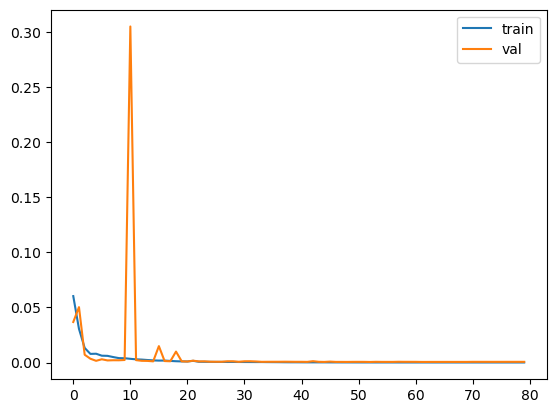

In [29]:
# plot the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [30]:
# test the model
test_loss = model.evaluate(test_gen)
print("Test loss:", test_loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 719ms/step - loss: 3.3023e-04 - mae: 0.0077 - mse: 7.4664e-04
Test loss: [0.0005207324284128845, 0.0011767965042963624, 0.009711484424769878]


## Inference

In [31]:
# # camera testing
# def predict_camera_image(image):
#     image = tf.image.resize(image, [256, 256])
#     image = tf.cast(image, tf.float16) / 255.0
#     image = tf.expand_dims(image, axis=0)
#     prediction = model.predict(image)
#     return prediction

In [32]:
# # open the camera
# cap = cv2.VideoCapture(0)
# while True:
#     ret, frame = cap.read()
    
#     # Preprocess the frame
#     frame = cv2.resize(frame, (256, 256))
#     frame = frame.astype(np.float16) / 255.0
    
#     # Make prediction
#     prediction = predict_camera_image(frame)
    
#     # Correct coordinates
#     coord1 = correct_coordinates(prediction[0, :2])
#     coord2 = correct_coordinates(prediction[0, 2:])
    
#     # Draw circles on the frame
#     cv2.circle(frame, coord1, 4, (255, 0, 0), -1)
#     cv2.circle(frame, coord2, 4, (0, 255, 0), -1)
    
#     # Display the frame
#     cv2.imshow('Real-time Prediction', frame)
    
#     # Break the loop if 'q' is pressed
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release the capture and destroy all windows
# cap.release()
# cv2.destroyAllWindows()